# makemore

An autoregressive character-level language model, which will generate 'similar' text in accordance to the input text.

In [1]:
import torch
import matplotlib.pyplot as plt

generator = torch.Generator().manual_seed(42) # ensure reproducibility

## 0. Data

In [2]:
# read input dataset
with open('names.txt', 'r', encoding='utf-8') as f:
    words = f.read().splitlines()

# create a list of names

In [3]:
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [4]:
print('Number of words:', len(words))
print('Shortest word length:', min(len(word) for word in words))
print('Longestword length:', max(len(word) for word in words))

Number of words: 32033
Shortest word length: 2
Longestword length: 15


What information can be extracted from the input data?

Taking just the name **Isabella**, as our dataset:

- We can infer that the character `i` has a strong probability of being the first letter of the name.
- The character `s` is likely to come after `i`. `a` is likely to come after `is`. `b` is likely to come after `isa`. And so forth.
- After `isabella`, the word is likely to end.

## 1. Bigram

The information used to make inferences about which character should come next is a sequence depends soley on the previous character.

In [5]:
# step through each character pair in the words
for word in words[:3]:
    # we can use the zip function to create the bigram pairs
    # zip takes two lists, and returns a list of tuples, where each ith tuple contains the ith elements from each list
    # word[1:] is an offset slice, which returns all elements of the list except the first
    # therefore the zip returns a tuple for each pair of characters in the word, as the second value in the tuple is offset by 1, and there is no corresponding value for the last character
    for char1, char2 in zip(word, word[1:]):
        print(char1, char2)
    print()

e m
m m
m a

o l
l i
i v
v i
i a

a v
v a



**Boundary Markers**

We need to recognise the beginning and end of a word, so that the model can learn that these initial characters are more likel to start, etc.

We can do this by hallucinating a start and end character for each word.

In [6]:
# step through each character pair in the words
for word in words[:3]:

    characters = ['^'] + list(word) + ['$'] # hallucinate start and end characters

    for bigram in zip(characters, characters[1:]):
        print(bigram[0], bigram[1])
    print()

^ e
e m
m m
m a
a $

^ o
o l
l i
i v
v i
i a
a $

^ a
a v
v a
a $



**Bigram Frequency**

We can now count the number of times each bigram occurs in the dataset.

In [7]:
bigrams = {}

# step through each character pair in the words
for word in words[:3]:

    characters = ['^'] + list(word) + ['$'] # hallucinate start and end characters
        
    for bigram in zip(characters, characters[1:]):
        bigrams[bigram] = bigrams.get(bigram, 0) + 1 # increment the count of the bigram

print(bigrams)

{('^', 'e'): 1, ('e', 'm'): 1, ('m', 'm'): 1, ('m', 'a'): 1, ('a', '$'): 3, ('^', 'o'): 1, ('o', 'l'): 1, ('l', 'i'): 1, ('i', 'v'): 1, ('v', 'i'): 1, ('i', 'a'): 1, ('^', 'a'): 1, ('a', 'v'): 1, ('v', 'a'): 1}


In [8]:
bigrams = {}

# step through each character pair in the words
for word in words:

    characters = ['^'] + list(word) + ['$'] # hallucinate start and end characters
        
    for bigram in zip(characters, characters[1:]):
        bigrams[bigram] = bigrams.get(bigram, 0) + 1 # increment the count of the bigram

temp = bigrams.items()
ascending = sorted(temp, key=lambda kv: kv[1])
descending = sorted(temp, key=lambda kv: -kv[1])

print(ascending[:10])
print()
print(descending[:10])

[(('q', 'r'), 1), (('d', 'z'), 1), (('p', 'j'), 1), (('q', 'l'), 1), (('p', 'f'), 1), (('q', 'e'), 1), (('b', 'c'), 1), (('c', 'd'), 1), (('m', 'f'), 1), (('p', 'n'), 1)]

[(('n', '$'), 6763), (('a', '$'), 6640), (('a', 'n'), 5438), (('^', 'a'), 4410), (('e', '$'), 3983), (('a', 'r'), 3264), (('e', 'l'), 3248), (('r', 'i'), 3033), (('n', 'a'), 2977), (('^', 'k'), 2963)]


**Bigram Frequency Table**

However, we want to store this information in a 2-dimensional matrix, where the rows represent the first character of the bigram and the columns represent the second character of the bigram.

In [9]:
print(
    torch.zeros(3, 5)
)

print(
    torch.zeros(3, 5, dtype=torch.int32)
)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)


### Tokenisation

We need to represent each entity as a numerical value. For example, using `1` instead of `a`. This allows us to store data positionally within a matrix, as we can now use this integer value to index the matrix.

In [10]:
vocabulary = ['^'] + sorted(list(set(''.join(words)))) + ['$']

ctoi = { c: i for i, c in enumerate(vocabulary) }
itoc = { i: c for i, c in enumerate(vocabulary) }

encode = lambda word: [ctoi[c] for c in list(word)]
decode = lambda code: ''.join([itoc[i] for i in code])

In [11]:
print(encode('a'))
print(decode(encode('helloworld')))

[1]
helloworld


In [12]:
frequencyTable = torch.zeros(28, 28, dtype=torch.int32)

# step through each character pair in the words
for word in words:

    characters = encode(['^'] + list(word) + ['$']) # hallucinate start and end characters
        
    for bigramIndexes in zip(characters, characters[1:]):
        frequencyTable[bigramIndexes] += 1 # increment the count of the bigram
        # bigramIndexes is the coordinates of the bigram in the frequencyTable
        # i.e. (0, 1) would be the location of [^, a]

print(frequencyTable)

tensor([[   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
         1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
          134,  535,  929,    0],
        [   0,  556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568,
         2528, 1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,
          182, 2050,  435, 6640],
        [   0,  321,   38,    1,   65,  655,    0,    0,   41,  217,    1,    0,
          103,    0,    4,  105,    0,    0,  842,    8,    2,   45,    0,    0,
            0,   83,    0,  114],
        [   0,  815,    0,   42,    1,  551,    0,    2,  664,  271,    3,  316,
          116,    0,    0,  380,    1,   11,   76,    5,   35,   35,    0,    0,
            3,  104,    4,   97],
        [   0, 1303,    1,    3,  149, 1283,    5,   25,  118,  674,    9,    3,
           60,   30,   31,  378,    0,    1,  424,   29,    4,   92,   17,   23,
            0,  317,    1,  516],
        [   0,  679,

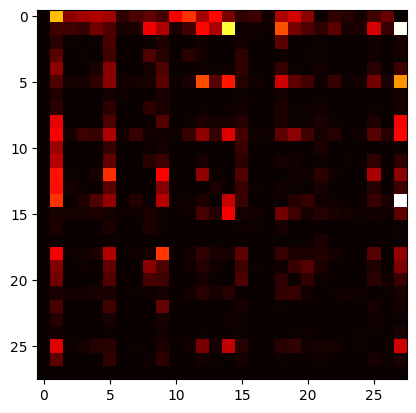

In [13]:
plt.imshow(frequencyTable, cmap='hot', interpolation='nearest')

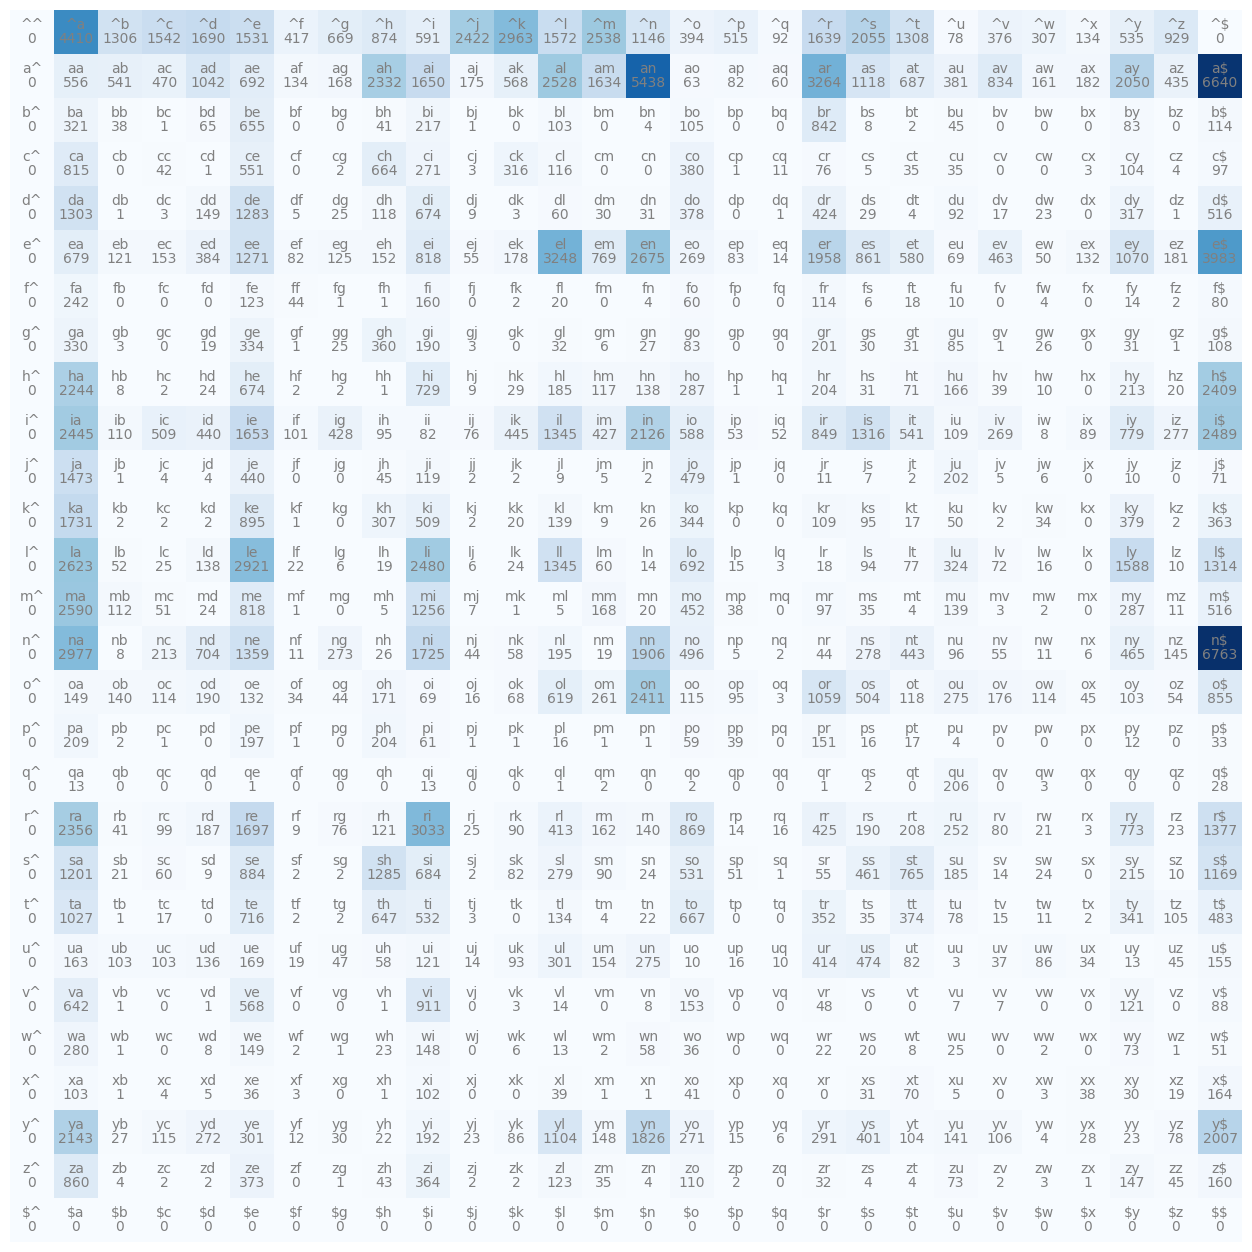

In [14]:
def showBigramHeatmap(counts, vocabulary):
    plt.figure(figsize=(16,16))
    plt.imshow(counts, cmap='Blues')
    for r in range(len(vocabulary)):
        for c in range(len(vocabulary)):
            chstr = itoc[r] + itoc[c]
            if (chstr == '$$'):
                chstr = '\$\$'
            plt.text(c, r, chstr, ha='center', va='bottom', color='gray')
            plt.text(c, r, counts[r, c].item(), ha='center', va='top', color='gray')
    plt.axis('off')

showBigramHeatmap(frequencyTable, vocabulary)

Notice that there are redundant combinations in this dataset. We know that `a^` can never occur, for example, as `^` is the start character.

We have a whole column ending with `^` and a whole row starting with `$`. We can remove these rows and columns, as they are redundant. The only exception is the `^$` cell (the empty word), which we will keep. This means, however, that we can just use a single character to represent the start and end of a word.

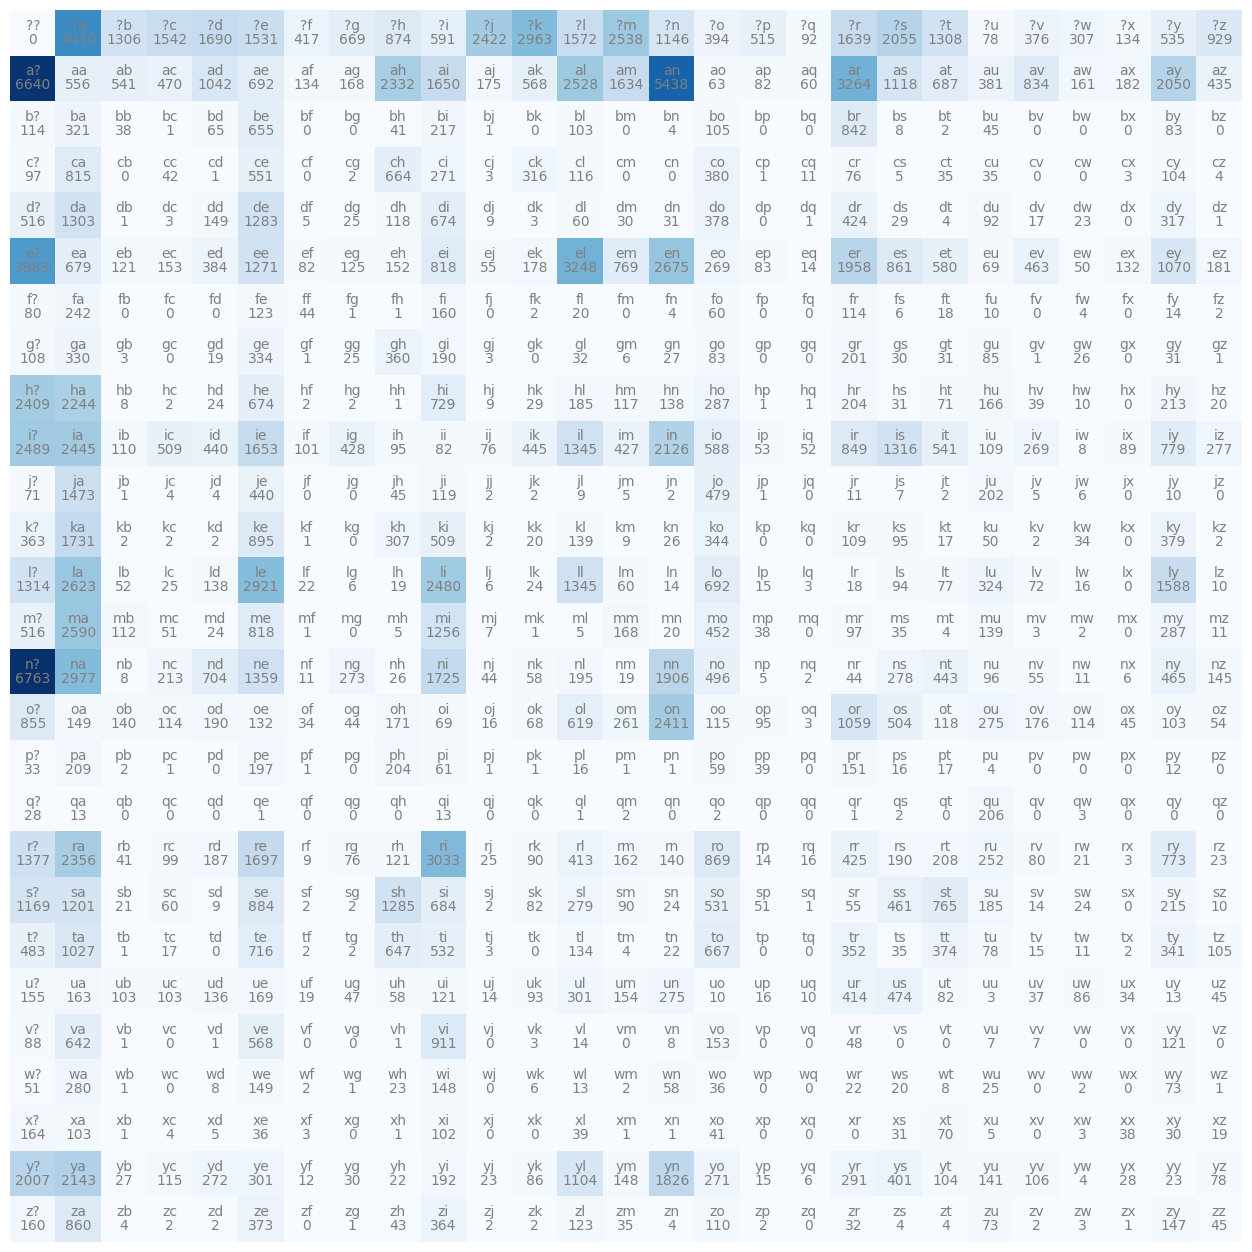

In [15]:
vocabulary = ['?'] + sorted(list(set(''.join(words))))
frequencyTable = torch.zeros(27, 27, dtype=torch.int32)

ctoi = { c: i for i, c in enumerate(vocabulary) }
itoc = { i: c for i, c in enumerate(vocabulary) }

# step through each character pair in the words
for word in words:

    characters = encode(['?'] + list(word) + ['?']) # hallucinate start and end characters
        
    for bigramIndexes in zip(characters, characters[1:]):
        frequencyTable[bigramIndexes] += 1 # increment the count of the bigram

showBigramHeatmap(frequencyTable, vocabulary)

### Sampling

We need to convert these counts into probabilities. We can do this via normalisation; dividing each row by the sum of the row, such that the sum of each row is 1.

#### Normalisation

We can divide each value by the sum of it's row, to normalise each row to `1`.

In [16]:
rowProbabilities = frequencyTable[0].float()
rowProbabilities /= rowProbabilities.sum() # normalise the probabilities

print(rowProbabilities)
print(rowProbabilities.sum())

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])
tensor(1.)


We can store this information within a matrix to replace our Bigram Frequency Table. This saves us from having to calculate the normalised values each time we want to sample from the distribution. This new matrix, the **Bigram Probability Table**, will be of the same dimensions as the Frequency Table.

This table will essentially just be the parameters of our model.

##### Broadcasting

When performing binary matrix operations, we can use a technique called broadcasting. This allows us to perform operations on matrices of different shapes, by expanding the smaller matrix to the shape of the larger matrix.

There are requirements on when broadcasting can be used:
1. The dimensions must be aligned.
2. For each dimension (right to left), the size of the dimension must be equal or one of the matrices must have a size of 1, or the dimension must be missing from one of the matrices.

In [17]:
probabilityTable = frequencyTable.float()
probabilityTable /= probabilityTable.sum(dim=1, keepdim=True) # normalise the probabilities
# divide each value in the table by the summation of its row (dimension = 1)

print((probabilityTable[0] == rowProbabilities).all()) # proof that the values in the first row are the same as the rowProbabilities

tensor(True)


#### Multinomial



In [18]:
probabilities = torch.rand(3, generator=generator)
probabilities /= probabilities.sum()
# this array holds the probability of its index being drawn from the multinomial distribution
# i.e. ~40% chance of 0, ~42% chance of 1, ~18% chance of 2
print(probabilities)

temp = torch.multinomial(probabilities, num_samples=20, replacement=True, generator=generator)
# this array holds the specified number of samples drawn from the multinomial distribution
print(temp)

tensor([0.4047, 0.4197, 0.1756])
tensor([1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 2])


In [19]:
rowProbabilities = probabilityTable[1] # 'a'
indexes = torch.multinomial(rowProbabilities, num_samples=1, replacement=True, generator=generator).item()
# sample a single index from the first row, using the multinomial distribution
# multiple samples can be drawn at once, by increasing the num_samples parameter
# this returns the index of the sampled value (aka the prediciton of what the next character will be)

# under the hood, the multinomial function is just drawing a random number,
# and then using the probabilities to determine which index the random number corresponds to

print(indexes)
print(decode([indexes]))
# likely this will predict that the next character is 'n'

14
n


### Using the Model

1. We can simply feed `?` into the model.
2. We then append the predicted character to a string, and feed this new character back into the model.
3. We repeat this process until we recieve a `?` as the output. This is the end of the word.

Et, voila.

In [20]:
newName = [ctoi['?']]

while (newName[-1] != ctoi['?'] or len(newName) == 1):

    lastChar = newName[-1]
    rowProbabilities = frequencyTable[lastChar].float()

    indexes = torch.multinomial(rowProbabilities, num_samples=1, replacement=True, generator=generator).item()
    newName.append(indexes)

print(decode(newName[1:-1])) # trim the start and end characters, and convert to a string

bellyamiiae


#### Uniform Distribution
(An untrained model, using pure random probability to genearate a sequence, for comparison)

In [21]:
newName = [ctoi['?']]

while (newName[-1] != ctoi['?'] or len(newName) == 1):

    lastChar = newName[-1]
    rowProbabilities = torch.ones(27) / 27.0

    indexes = torch.multinomial(rowProbabilities, num_samples=1, replacement=True, generator=generator).item()
    newName.append(indexes)

print(decode(newName[1:-1])) # trim the start and end characters, and convert to a string

ybkejmszqsqgtoyzjovtkimpupooznnyzujfosjvslrumxtonaclpgcyaqxknvzioiuqrtensqvgsumjqwqeioionyyrmnyctrjzdwtyazxdbpnftaauzyskakoth


### Evaluation

#### Likelihood of Data
We can evaluate the model to assess how well it is performing. For example, we can look at each bigram that appears in our initial dataset, and see how often the model predicts the correct next character.

Each probability of these real values should exceed the probability of the uniform distribution (`1/27 = 0.037...`).

In [22]:
# step through each character pair in the words
for word in words[:3]:

    characters = ['?'] + list(word) + ['?'] # hallucinate start and end characters

    for bigram in zip(characters, characters[1:]):
        probability = probabilityTable[ctoi[bigram[0]], ctoi[bigram[1]]]
        print(bigram[0], bigram[1], round(probability.item(), 4))
    print()

? e 0.0478
e m 0.0377
m m 0.0253
m a 0.3899
a ? 0.196

? o 0.0123
o l 0.078
l i 0.1777
i v 0.0152
v i 0.3541
i a 0.1381
a ? 0.196

? a 0.1377
a v 0.0246
v a 0.2495
a ? 0.196



#### Likelihood of Dataset
However, we want to calcualte the quality of a model over the whole dataset as measured by a single number. This is the **loss** of the model.

To achieve this, instead of evaluating each individual bigram within it, we can calculate the product of the likelihood of each bigram in the dataset (product of all values displayed above).

`p(D) = p(d1) * p(d2) * ... * p(dn)`

##### Log-Likelihood
However, as each of these values are `0 <= p(di) <= 1`, the product of all of them will be very small. To avoid this, we can take the log of each value, and then sum them. This is called the **log-likelihood**.

`log(a * b) = log(a) + log(b)`

In [23]:
# step through each character pair in the words
for word in words[:1]:
    characters = ['?'] + list(word) + ['?'] # hallucinate start and end characters

    for bigram in zip(characters, characters[1:]):
        probability = probabilityTable[ctoi[bigram[0]], ctoi[bigram[1]]]
        logLikelihood = torch.log(probability)
        print(bigram[0], bigram[1], round(logLikelihood.item(), 4))
    print()

logLikelihood = 0.0

# step through each character pair in the words
for word in words:
    characters = ['?'] + list(word) + ['?'] # hallucinate start and end characters

    for bigram in zip(characters, characters[1:]):
        probability = probabilityTable[ctoi[bigram[0]], ctoi[bigram[1]]]
        logLikelihood += torch.log(probability)
print(logLikelihood)

? e -3.0408
e m -3.2793
m m -3.6772
m a -0.9418
a ? -1.6299



tensor(-559891.7500)


This value will be close to `0` if the model is good, and far if the model is bad.

##### Negative Log-Likelihood

However, we want to maximise this value, so we can take the negative of it, to get the **negative log-likelihood**.

`-log(a * b) = -log(a) - log(b)`

In [24]:
negativeLogLikelihood = 0.0
count = 0

# step through each character pair in the words
for word in words:
    characters = ['?'] + list(word) + ['?'] # hallucinate start and end characters

    for bigram in zip(characters, characters[1:]):
        count += 1

        probability = probabilityTable[ctoi[bigram[0]], ctoi[bigram[1]]]
        negativeLogLikelihood -= torch.log(probability)

print(negativeLogLikelihood)

tensor(559891.7500)


##### Average Negative Log-Likelihood
Typically, we will also average this value over the number of bigrams in the dataset, to get the **average negative log-likelihood**.

`ANLL = NLL / n`

In [25]:
normalisedNegativeLogLikelihood = negativeLogLikelihood / count
print(normalisedNegativeLogLikelihood)

tensor(2.4541)


For evaluation, we want to maximise the likelihood of the dataset, with regards to the model paramaters.

In this case, we want to therefore...
1. Maximise the the log-likelihood.
2. ergo, minimise the negative log-likelihood.
3. ergo, minimise the average negative log-likelihood.

This is our **loss** function.

### Model Smoothing

There can be cases where the model is ovefitting to the data, as there are some bigrams which are not present in the dataset. For example, we can caluclate the negative log-likehood of the the data entry `amitda`, which is a valid name outside of our dataset.

In [26]:
negativeLogLikelihood = 0.0

# step through each character pair in the words
characters = ['?'] + list('amitda') + ['?'] # hallucinate start and end characters

for bigram in zip(characters, characters[1:]):

    probability = probabilityTable[ctoi[bigram[0]], ctoi[bigram[1]]]
    print(bigram[0], bigram[1], round(probability.item(), 4))

    negativeLogLikelihood -= torch.log(probability)

print()
print(negativeLogLikelihood)

? a 0.1377
a m 0.0482
m i 0.1891
i t 0.0306
t d 0.0
d a 0.2371
a ? 0.196

tensor(inf)


We can see that the NLL of this entry is `inf`, as the model has never seen the bigram `td` before in the training dataset. This means there is a `0` probability of this name ever being generated, even though it is a valid name.

To fix this, we can use a technique called **smoothing**. This involves adding a small value to each cell in the Bigram Probability Table, to ensure that no cell has a probability of `0`.

The greater the value added, the smoother the model will be. However, this also adds a bias to the model, towards the uniform distribution, meaning it will be less likely to generate data according to the training dataset. This is a trade-off.

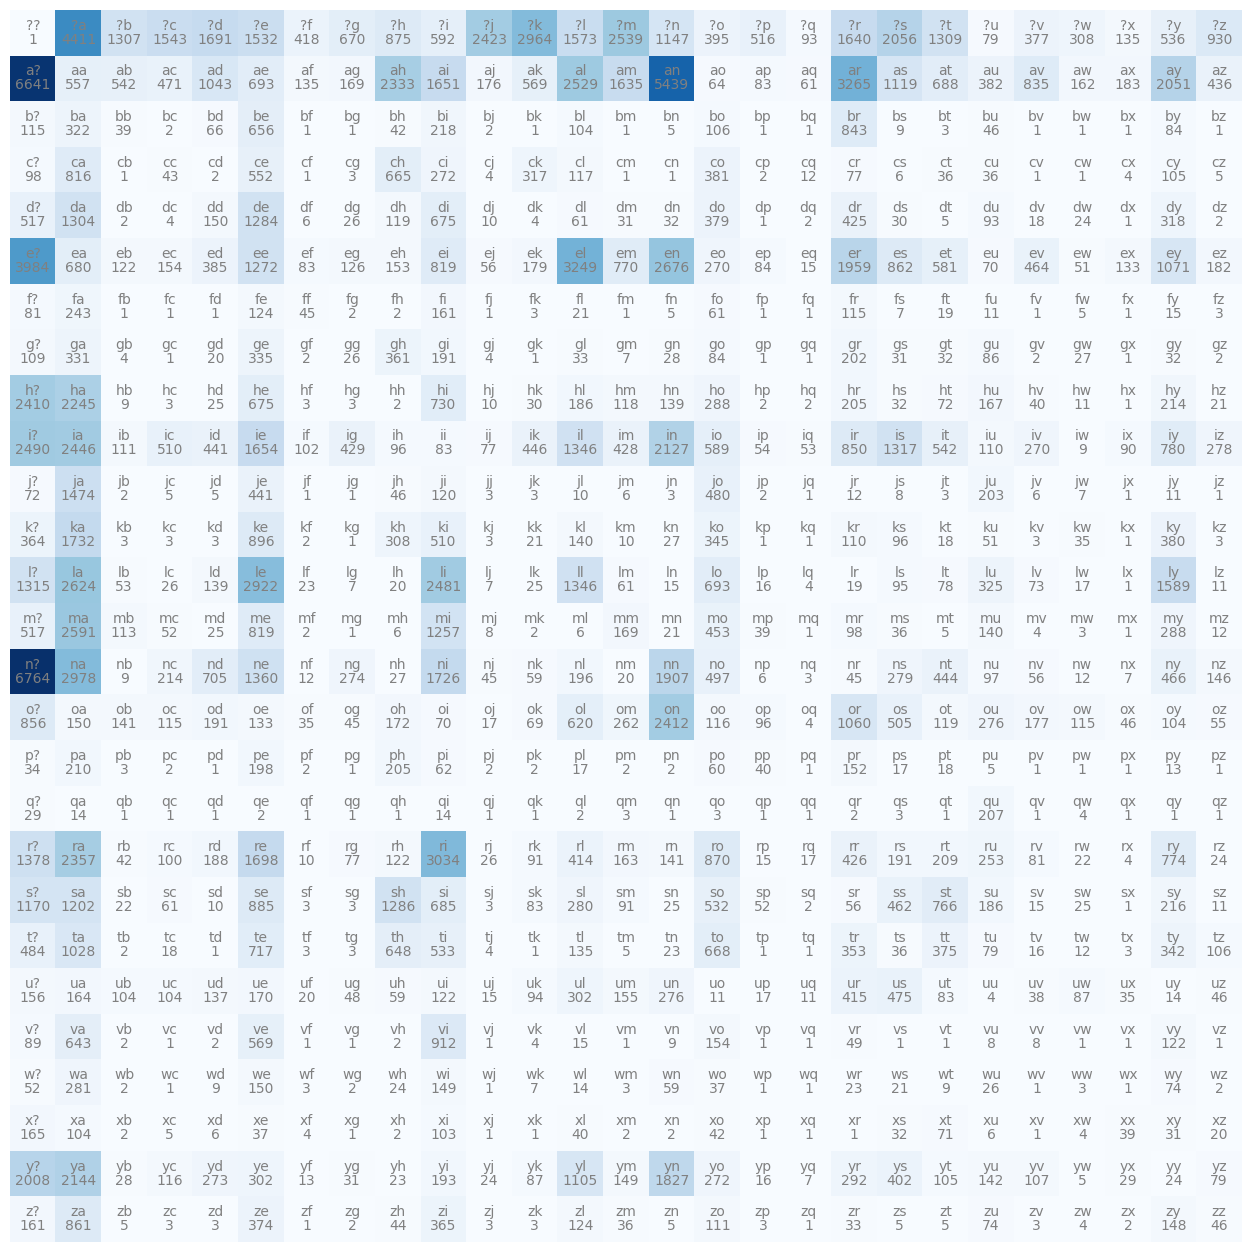

In [27]:
probabilityTable = (frequencyTable + 1).float() # manually one, although in actual implementation, we could just initialy instantiate the table with 1s
probabilityTable /= probabilityTable.sum(dim=1, keepdim=True)

showBigramHeatmap(frequencyTable + 1, vocabulary)

In [28]:
negativeLogLikelihood = 0.0

# step through each character pair in the words
characters = ['?'] + list('amitda') + ['?'] # hallucinate start and end characters

for bigram in zip(characters, characters[1:]):

    probability = probabilityTable[ctoi[bigram[0]], ctoi[bigram[1]]]
    print(bigram[0], bigram[1], round(probability.item(), 4))

    negativeLogLikelihood -= torch.log(probability)

print()
print(negativeLogLikelihood)

? a 0.1376
a m 0.0482
m i 0.1885
i t 0.0306
t d 0.0002
d a 0.2361
a ? 0.1958

tensor(21.8760)


It is still _very_ rare the the model will generate `td` (`0.0002` probability), but it is now possible.

In [29]:
# generation example with new, smoothed model
newName = [ctoi['?']]

while (newName[-1] != ctoi['?'] or len(newName) == 1):

    lastChar = newName[-1]
    rowProbabilities = frequencyTable[lastChar].float()

    indexes = torch.multinomial(rowProbabilities, num_samples=1, replacement=True, generator=generator).item()
    newName.append(indexes)

print(decode(newName[1:-1])) # trim the start and end characters, and convert to a string

eyamilyi
